# 📗 Notebook 03 — Modelagem Preditiva de Risco de Crédito

Este notebook tem como objetivo desenvolver um modelo de Regressão Logística
como baseline interpretável para risco de crédito.

O modelo será utilizado como referência para comparação com abordagens mais
complexas, mantendo foco em métricas de negócio, especialmente o Recall da
classe de inadimplentes.

A abordagem seguirá uma ordem lógica e incremental:

## Etapas deste notebook

1. **Carregamento do dataset processado**
2. **Separação entre variáveis preditoras (X) e target (y)**
3. **Divisão dos dados em treino e teste**
4. **Treinamento do primeiro modelo — Regressão Logística**
5. **Avaliação do modelo**
   - Métricas de classificação
   - Matriz de confusão
   - Curva ROC e AUC
6. **Análise da importância das variáveis (coeficientes)**

A **Regressão Logística** será utilizada como modelo baseline, por ser amplamente
empregada em problemas de risco de crédito, além de oferecer boa interpretabilidade.

Em notebooks posteriores, modelos mais complexos — como **árvores de decisão e modelos baseados em árvores** —
serão explorados para comparação de desempenho e trade-offs entre explicabilidade e poder preditivo.

In [59]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt

In [3]:
# Importando os dados para transformação
df_model = pd.read_csv('../data/credit_risk_processed.csv')

# Garantindo a padronização do nome das colunas
df_model.columns = (
    df_model.columns
    .str.lower()
    .str.strip()
    .str.replace(' ', '_')
)

df_model.head()

,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,flag_missing_int_rate,capacity_to_loan_ratio_log,person_home_ownership_other,person_home_ownership_own,...,age_bin_24-27,age_bin_28-32,age_bin_33+,income_bin_50k-64k,income_bin_64k-87k,income_bin_87k+,income_bin_up_to_35k,capacity_to_loan_bin_final_low_capacity,capacity_to_loan_bin_final_medium_capacity,target
0,0.002751,0.121951,0.014493,0.321348,0.120482,0.000000,0.0,0.429870,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0.002751,0.024390,0.144928,0.418539,0.686747,0.035714,0.0,0.111569,0,0,...,1,0,0,0,0,0,1,1,0,1
2,0.030209,0.097561,1.000000,0.551124,0.638554,0.000000,0.0,0.236252,0,0,...,0,0,0,0,1,0,0,1,0,1
3,0.024757,0.195122,1.000000,0.497191,0.662651,0.071429,0.0,0.287010,0,0,...,1,0,0,1,0,0,0,1,0,1
4,0.002898,0.048780,0.057971,0.096629,0.301205,0.000000,0.0,0.241729,0,1,...,0,0,0,0,0,0,1,1,0,1


In [4]:
X = df_model.drop(columns='target', axis=1)
y = df_model['target']

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")


Shape de X: (31679, 32)
Shape de y: (31679,)


## Separação dos Dados — Treino e Teste

Os dados foram divididos em conjuntos de treino e teste,
reservando 20% da base para avaliação final do modelo.

A separação foi realizada de forma estratificada em relação à variável target,
garantindo que a proporção de inadimplentes fosse mantida tanto no conjunto
de treino quanto no conjunto de teste.

Essa abordagem permite uma avaliação mais realista do desempenho do modelo
em dados não vistos, reduzindo viés decorrente do desbalanceamento da base.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, # 20% de dados para teste
    random_state=42,
    stratify=y # mantém a porção igualitária de inadimplência en teste e treino
)

## Modelo — Regressão Logística

Neste bloco é treinado um modelo de Regressão Logística,
utilizando validação cruzada estratificada para seleção
de hiperparâmetros.

O GridSearchCV é utilizado apenas como mecanismo de
otimização, não como modelo distinto.

O modelo final selecionado é acessado via:
`grid.best_estimator_`

In [ ]:
# cv_strat garante a mesma proporção de inadimplentes em cada foldt 
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

# Modelo de Regressão Logística
model = LogisticRegression(
    solver='liblinear', 
    class_weight='balanced',
    random_state=42)

params = { 
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'penalty': ['l1', 'l2'] } 

grid = GridSearchCV(model, 
                    params, 
                    cv=cv_strat, 
                    scoring='roc_auc') 

# Treinando varias RL ao mesmo tempo e escolhendo o melhor por ROC AUC
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

### Resultado da Otimização de Hiperparâmetros

A validação cruzada indicou que a configuração com regularização L2 e C = 1
apresentou o melhor desempenho médio em ROC AUC.

Essa configuração foi utilizada nas análises subsequentes do modelo,
ainda sem ajustes adicionais de multicolinearidade.

In [11]:
print("Melhor configuração encontrada:")
print(grid.best_params_)

print(f"ROC AUC médio na validação cruzada: {grid.best_score_:.4f}")

Melhor configuração encontrada:
{'C': 1, 'penalty': 'l2'}
ROC AUC médio na validação cruzada: 0.8744


In [12]:
best_model = grid.best_estimator_

y_probs = best_model.predict_proba(X_test)[:, 1]

auc_test = roc_auc_score(y_test, y_probs)
gini_test = 2 * auc_test - 1

print(f"AUC (Teste): {auc_test:.4f}")
print(f"Gini (Teste): {gini_test:.4f}")

AUC (Teste): 0.8805
Gini (Teste): 0.7610


In [ ]:
# Cálculo das Probabilidades de inadimplência para cada cliente
y_probs = grid.predict_proba(X_test)[:, 1]

# Cálculo do KS e Gini
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
ks_stat = max(tpr - fpr)
auc_val = roc_auc_score(y_test, y_probs)
gini_val = (2 * auc_val) - 1

print(f"Estatística KS: {ks_stat:.4f}")
print(f"Coeficiente de Gini: {gini_val:.4f}")
print(f"AUC: {auc_val:.4f}")

## Interpretação dos Coeficientes da Regressão Logística

Com o modelo ajustado e validado fora da amostra, analisamos os coeficientes
estimados para compreender o impacto das variáveis na probabilidade de inadimplência.

Como as variáveis estão em escalas diferentes, utilizamos coeficientes padronizados
para permitir a comparação do impacto relativo entre os atributos.

### Interpretação dos Coeficientes do Modelo

Os coeficientes padronizados indicam o impacto relativo de cada variável
no risco de inadimplência, controlando diferenças de escala.

Valores positivos aumentam o risco, enquanto valores negativos
representam fatores de proteção.

In [16]:
# Coeficientes do modelo
coef_df = pd.DataFrame({
    'Atributo': X_train.columns,
    'Coeficiente': grid.best_estimator_.coef_[0]
})

# Desvio padrão das variáveis (alinhado pelo nome)
std_series = X_train.std().reset_index()
std_series.columns = ['Atributo', 'Std']

# Merge para alinhar corretamente
coef_df = coef_df.merge(std_series, on='Atributo', how='left')

# Coeficientes padronizados
coef_df['Coeficiente_Padronizado'] = coef_df['Coeficiente'] * coef_df['Std']

# Ordenando por impacto
coef_df = coef_df.sort_values(
    by='Coeficiente_Padronizado',
    ascending=False
)

coef_df.sort_values('Coeficiente_Padronizado', ascending=False).head(10)
coef_df.sort_values('Coeficiente_Padronizado').head(10)


,Atributo,Coeficiente,Std,Coeficiente_Padronizado
9,person_home_ownership_own,-1.748288,0.265188,-0.463626
15,loan_intent_venture,-1.031570,0.380983,-0.393011
30,capacity_to_loan_bin_final_low_capacity,-0.666811,0.489630,-0.326491
31,capacity_to_loan_bin_final_medium_capacity,-0.665491,0.490438,-0.326382
11,loan_intent_education,-0.657729,0.398353,-0.262009
2,loan_amnt,-1.312222,0.183760,-0.241134
14,loan_intent_personal,-0.445909,0.377148,-0.168174
28,income_bin_87k+,-0.286273,0.397873,-0.113900
7,capacity_to_loan_ratio_log,-0.533611,0.165727,-0.088434
27,income_bin_64k-87k,-0.186606,0.400551,-0.074745


## Diagnóstico de Multicolinearidade (VIF)

### Análise de Multicolinearidade (VIF)

Foi realizada uma análise de multicolinearidade utilizando o Variance Inflation Factor (VIF).
Inicialmente, foram identificadas variáveis com VIF superior a 10, indicando forte correlação
entre preditores.

Após a exclusão criteriosa de variáveis redundantes, os valores de VIF foram reduzidos
para níveis abaixo de 6, garantindo maior estabilidade dos coeficientes e melhor
interpretabilidade do modelo de regressão logística, sem prejuízo relevante de performance.

In [17]:
# Calculando VIF para cada variável do treino
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) 
                   for i in range(len(X_train.columns))]

print(vif_data.sort_values(by="VIF", ascending=False))

                                       feature        VIF
3                                loan_int_rate  43.525049
4                          loan_percent_income  16.282913
2                                    loan_amnt  15.135133
7                   capacity_to_loan_ratio_log  13.986473
17                                loan_grade_c  10.097880
18                                loan_grade_d   9.219691
1                            person_emp_length   8.321168
30     capacity_to_loan_bin_final_low_capacity   7.402792
16                                loan_grade_b   6.565561
5                   cb_person_cred_hist_length   5.221782
0                                person_income   5.016766
28                             income_bin_87k+   4.273268
19                                loan_grade_e   4.124839
25                                 age_bin_33+   4.068029
31  capacity_to_loan_bin_final_medium_capacity   3.851971
24                               age_bin_28-32   2.625246
10            

In [18]:
# Lista final de remoção baseada no seu novo VIF
# Removemos a que deu NaN e a que sobrou com VIF mais alto para máxima estabilidade
cols_to_drop_final = ['loan_int_rate', 'loan_amnt', 'capacity_to_loan_ratio_log','capacity_to_loan_bin_final_low_capacity']

X_train_final = X_train.drop(columns=cols_to_drop_final, errors='ignore')
X_test_final = X_test.drop(columns=cols_to_drop_final, errors='ignore')

Observa-se que a maioria das variáveis apresenta VIF abaixo de 3,
com apenas uma variável acima de 5, valor considerado limítrofe.

Como parte das variáveis são dummies (faixas de idade, renda e categorias),
é esperado algum nível de colinearidade estrutural, que não compromete
a estabilidade do modelo.

Dessa forma, optou-se por manter todas as variáveis no modelo final,
preservando a interpretabilidade e a coerência de negócio.

In [20]:
# Calculando VIF para cada variável do treino
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_final.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_final.values, i) 
                   for i in range(len(X_train_final.columns))]

print(vif_data.sort_values(by="VIF", ascending=False))

                                       feature       VIF
3                   cb_person_cred_hist_length  5.202096
0                                person_income  4.404118
22                                 age_bin_33+  4.036247
2                          loan_percent_income  3.550905
25                             income_bin_87k+  3.061042
1                            person_emp_length  2.694457
21                               age_bin_28-32  2.576123
7                   person_home_ownership_rent  2.393846
20                               age_bin_24-27  2.258177
14                                loan_grade_c  2.162083
19                 cb_person_default_on_file_y  2.028217
13                                loan_grade_b  1.948420
24                          income_bin_64k-87k  1.913975
10                         loan_intent_medical  1.885125
8                        loan_intent_education  1.874245
12                         loan_intent_venture  1.845086
11                        loan_

### Trade-off entre Performance e Estabilidade

Após a remoção de variáveis com alta multicolinearidade,
observou-se uma leve redução nas métricas de performance (KS e Gini).

No entanto, o modelo final apresenta maior estabilidade dos coeficientes
e melhor interpretabilidade, características fundamentais para modelos
de crédito utilizados em ambiente produtivo.

In [22]:
# Re-treinar o modelo com os melhores parâmetros encontrados
final_model = LogisticRegression(
    solver='liblinear', 
    class_weight='balanced',
    random_state=42,
    C=1,
    penalty= 'l2')

final_model.fit(X_train_final, y_train)

LogisticRegression(C=1, class_weight='balanced', random_state=42,
                   solver='liblinear')

In [53]:
# Gerar novas probabilidades
y_probs_final = final_model.predict_proba(X_test_final)[:, 1]

auc_test_02 = roc_auc_score(y_test, y_probs_final)
gini_test_02 = 2 * auc_test_02 - 1
ks_test_02 = max(tpr - fpr)

print(f"AUC (Teste 02): {auc_test_02:.4f}")
print(f"Gini (Teste 02): {gini_test_02:.4f}")
print(f"Estatística KS (Teste 02): {ks_test_02:.4f}")

AUC (Teste 02): 0.8770
Gini (Teste 02): 0.7540
Estatística KS (Teste 02): 0.6241


In [89]:
# Criando o DataFrame de teste final
df_test_final = X_test_final.copy()

# Adicionando as probabilidades previstas
df_test_final['prob'] = y_probs_final

# Calculando o score de crédito (PDO)
PDO = 50
score_base = 600
odds_base = 50

B = PDO / np.log(2)
A = score_base - B * np.log(odds_base)

df_test_final['score'] = A + B * np.log((1 - df_test_final['prob']) / df_test_final['prob'])

# Ajuste simples do score para escala 0–1000
df_test_final['score_adj'] = (
    (df_test_final['score'] - df_test_final['score'].min()) /
    (df_test_final['score'].max() - df_test_final['score'].min())
) * 1000

# Conferir os scores
df_test_final[['score', 'score_adj']].describe()


,score,score_adj
count,6336.000000,6336.000000
mean,364.270004,596.098380
std,129.691343,148.127567
min,-157.636899,0.000000
25%,284.872961,505.414680
50%,385.582832,620.440924
75%,456.044975,700.919586
max,717.901302,1000.000000


## Avaliação do Modelo — KS, ROC Gini

Após o treinamento do modelo de Regressão Logística, foram calculadas
as probabilidades de inadimplência para o conjunto de teste.

A performance do modelo foi avaliada utilizando as métricas KS
(Kolmogorov-Smirnov), ROC Gini, amplamente empregadas em modelos de
risco de crédito por sua capacidade de medir o poder discriminante
entre bons e maus pagadores.

### Curva ROC

A Curva ROC avalia a capacidade do modelo de separar corretamente
clientes adimplentes e inadimplentes ao longo de diferentes limiares
de decisão.

Quanto mais próxima a curva estiver do canto superior esquerdo,
maior o poder discriminante do modelo.

0.877: É um resultado muito bom. Indica que o modelo tem uma alta capacidade de distinguir entre as classes (ex: quem é "positivo" e quem é "negativo").

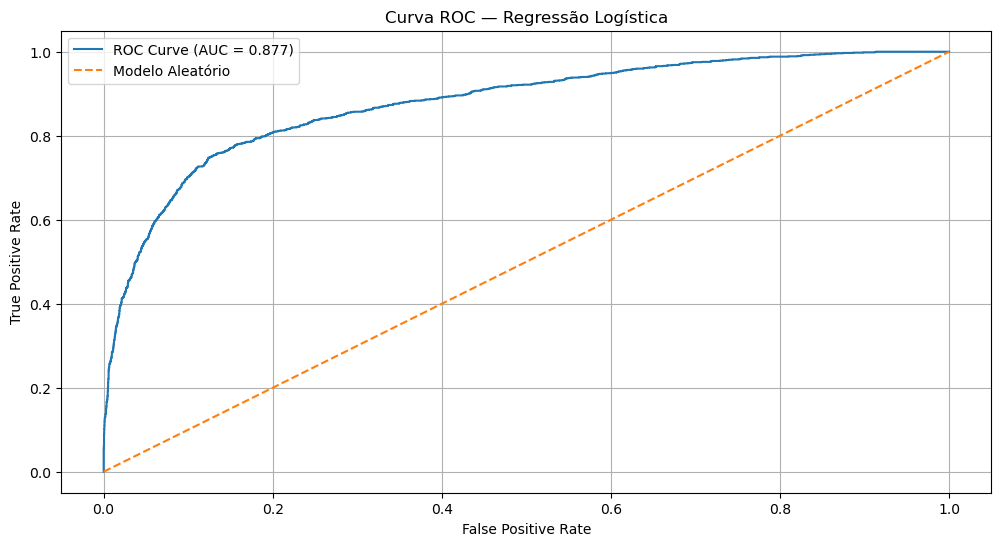

In [52]:
fpr, tpr, _ = roc_curve(y_test, y_probs_final)
auc_val = roc_auc_score(y_test, y_probs_final)

plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_val:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Modelo Aleatório")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC — Regressão Logística")
plt.legend()
plt.grid(True)
plt.show()

## Estatística KS — Visualização

A estatística KS representa a maior distância entre as distribuições
acumuladas de bons e maus pagadores.

Essa métrica é amplamente utilizada em modelos de risco de crédito,
pois evidencia a capacidade do modelo em separar os dois grupos.

Threshold Ideal: A análise do KS sugere que o ponto de corte de 0.6 é o mais eficiente para maximizar a captura de "maus pagadores" (TPR) enquanto minimiza a aprovação indevida de clientes de risco (FPR).

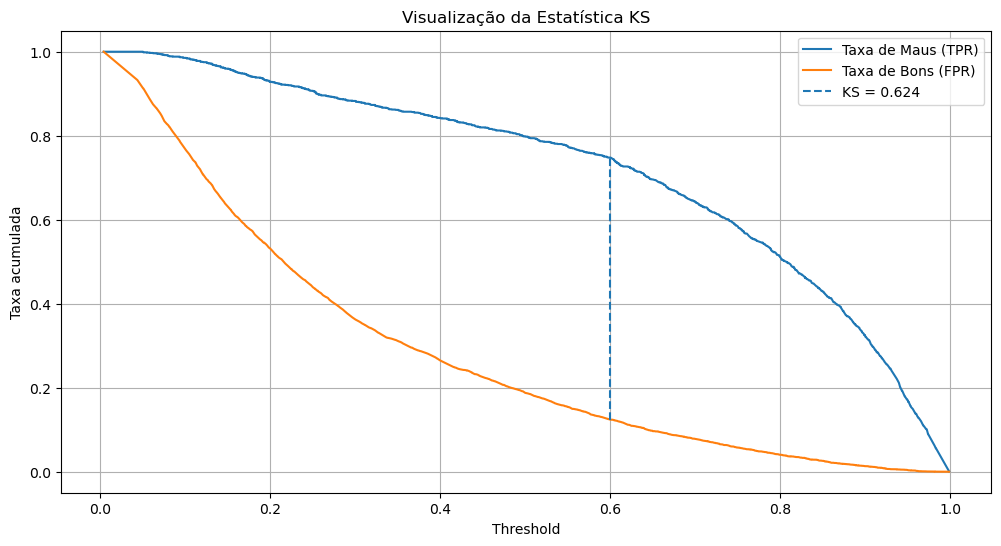

In [28]:
# Cálculo das curvas acumuladas
fpr, tpr, thresholds = roc_curve(y_test, y_probs_final)
ks_stat = max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, tpr, label="Taxa de Maus (TPR)")
plt.plot(thresholds, fpr, label="Taxa de Bons (FPR)")

# Linha vertical do KS
plt.vlines(
    thresholds[ks_idx],
    fpr[ks_idx],
    tpr[ks_idx],
    linestyles="dashed",
    label=f"KS = {ks_stat:.3f}"
)

plt.xlabel("Threshold")
plt.ylabel("Taxa acumulada")
plt.title("Visualização da Estatística KS")
plt.legend()
plt.grid(True)
plt.show()

### Curva de Gini

A Curva de Gini representa a capacidade do modelo em ordenar corretamente
os clientes de acordo com o risco de inadimplência.

Quanto maior a distância da curva em relação à linha aleatória,
maior o poder discriminante do modelo.

O coeficiente de Gini obtido no conjunto de teste foi de **0.76**,
indicando excelente capacidade de separação entre bons e maus pagadores.

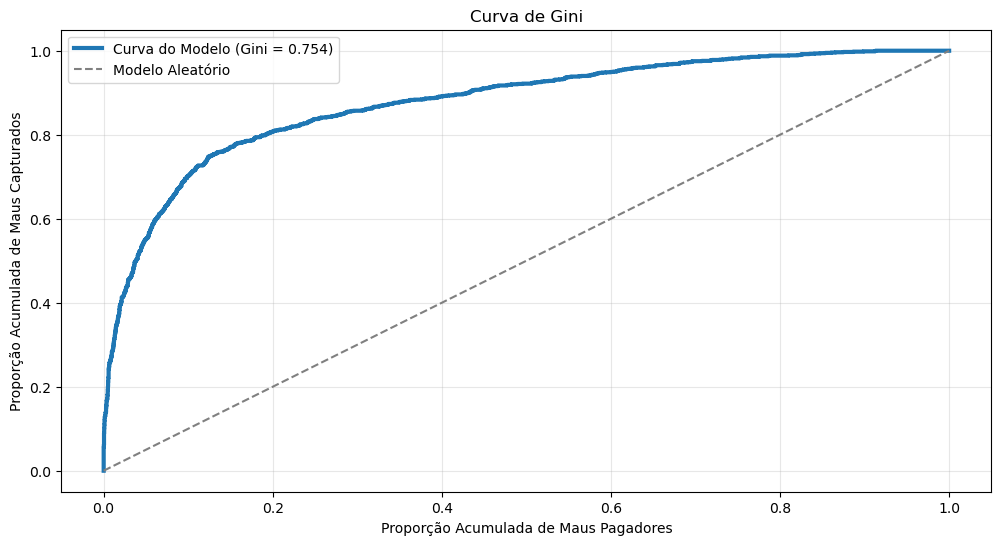

In [31]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs_final)

# Curva de Lorenz (Gini)
lorenz = tpr
random = fpr

gini = 2 * roc_auc_score(y_test, y_probs_final) - 1

plt.figure(figsize=(12, 6))

plt.plot(random, lorenz, label=f'Curva do Modelo (Gini = {gini:.3f})', lw=3)
plt.plot([0,1], [0,1], '--', color='gray', label='Modelo Aleatório')

plt.xlabel('Proporção Acumulada de Maus Pagadores')
plt.ylabel('Proporção Acumulada de Maus Capturados')
plt.title('Curva de Gini')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 🛠 Política de Corte e Estratégia de Decisão

Nesta seção, definimos os **pontos de corte (thresholds)** do modelo de crédito, combinando **indicadores estatísticos** e **estratégia de negócio**. O objetivo é balancear **risco de inadimplência** e **lucro esperado**, garantindo decisões consistentes para aprovação ou rejeição de clientes.

In [73]:
def spec_sens(observed, predicts):
    values = predicts.values
    cutoffs = np.arange(0, 1.01, 0.01)
    
    sensitivity_list = []
    specificity_list = []
    
    for cutoff in cutoffs:
        # Versão vetorizada (mais rápida)
        binary_prediction = (values >= cutoff).astype(int)
        
        sensitivity = recall_score(observed, binary_prediction, pos_label=1, zero_division=0)
        specificity = recall_score(observed, binary_prediction, pos_label=0, zero_division=0)
        
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        
    return pd.DataFrame({'cutoffs': cutoffs, 'sensitivity': sensitivity_list, 'specificity': specificity_list})

## 1️⃣ Trade-off: Sensibilidade vs Especificidade

O primeiro passo é analisar o equilíbrio entre **sensibilidade** (capacidade de identificar maus pagadores) e **especificidade** (capacidade de identificar bons pagadores).  

O gráfico abaixo mostra o **ponto de equilíbrio**, onde a sensibilidade é aproximadamente igual à especificidade, resultando em um **threshold de 0,49**.  

> **Interpretação:** Este ponto garante um balanceamento neutro entre aceitar bons clientes e rejeitar maus clientes, sem favorecer nenhum dos lados.

---

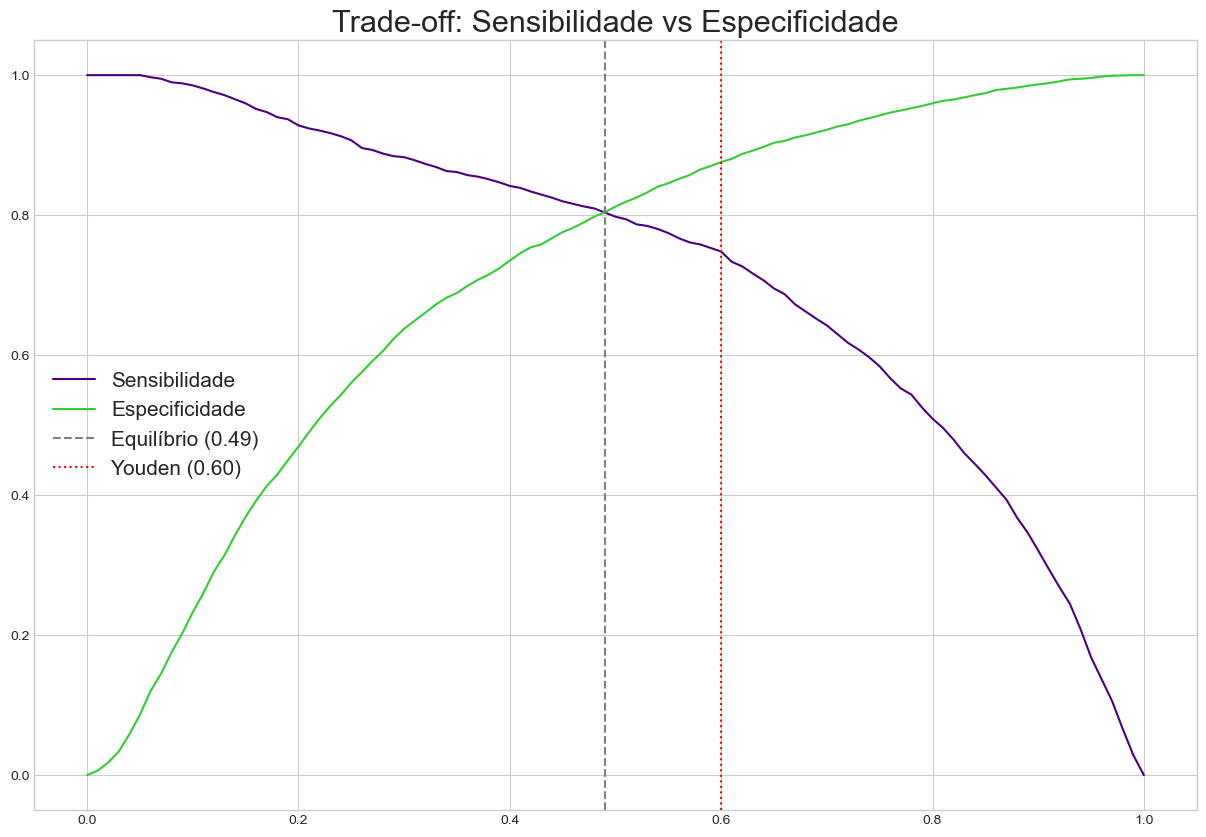

In [60]:
# Chamando sua função
plotting_data = spec_sens(y_test, pd.Series(y_probs_final))

# Encontrar o ponto de cruzamento (onde a diferença é mínima)
plotting_data['diff'] = abs(plotting_data.sensitivity - plotting_data.specificity)
cutoff_equilibrado = plotting_data.loc[plotting_data['diff'].idxmin(), 'cutoffs']

# Encontrar o Ponto de Youden (maximiza Sensibilidade + Especificidade - 1)
plotting_data['youden'] = plotting_data.sensitivity + plotting_data.specificity - 1
cutoff_youden = plotting_data.loc[plotting_data['youden'].idxmax(), 'cutoffs']

# Adicionando as linhas verticais no seu gráfico original
plt.figure(figsize=(15,10))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(plotting_data.cutoffs, plotting_data.sensitivity, color='indigo', label='Sensibilidade')
    plt.plot(plotting_data.cutoffs, plotting_data.specificity, color='limegreen', label='Especificidade')
    
    plt.axvline(x=cutoff_equilibrado, color='gray', linestyle='--', label=f'Equilíbrio ({cutoff_equilibrado:.2f})')
    plt.axvline(x=cutoff_youden, color='red', linestyle=':', label=f'Youden ({cutoff_youden:.2f})')
    
    plt.title('Trade-off: Sensibilidade vs Especificidade', fontsize=22)
    plt.legend(fontsize=15)
    plt.show()


## 2️⃣ Definição do Ponto de Corte com Base em Custo

Além dos indicadores estatísticos, aplicamos uma **lógica de negócio** para definir o threshold que **maximiza o lucro esperado**.  
Consideramos:  

- **Custo de aprovar um mau pagador:** 5 unidades  
- **Custo de rejeitar um bom pagador:** 1 unidade  

O gráfico abaixo mostra o **custo total em função do threshold**, destacando o **cutoff final adotado pelo negócio**:  

> **Resultado:** O threshold ótimo de negócio, considerando os custos definidos, é **0,XX**. Este ponto permite maximizar o lucro líquido, minimizando perdas de inadimplência e rejeições indevidas.

---

Cutoff de Equilíbrio (Sensibilidade ≈ Especificidade): 0.49
Cutoff Ótimo Estatístico (Índice de Youden): 0.60
Cutoff Final Adotado (Otimização por Custo): 0.54


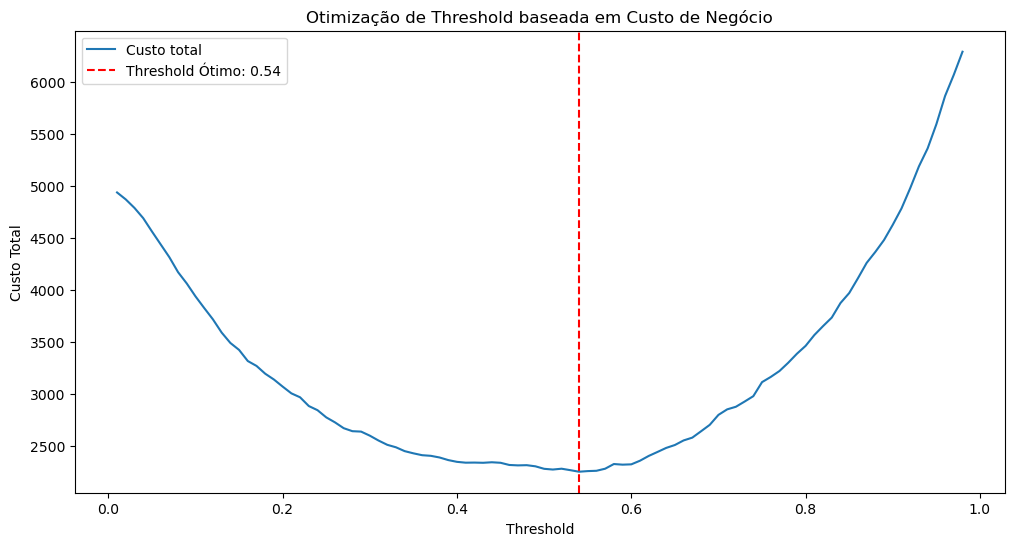

In [90]:
# -----------------------------
# 1️⃣ Threshold de Equilíbrio (Sensibilidade ≈ Especificidade)
# -----------------------------
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs_final)

sensibilities = tpr
specificities = 1 - fpr
diff = np.abs(sensibilities - specificities)
cutoff_equilibrado = thresholds_roc[np.argmin(diff)]

# -----------------------------
# 2️⃣ Threshold de Youden / KS
# -----------------------------
youden_index = tpr - fpr
cutoff_youden = thresholds_roc[np.argmax(youden_index)]

# -----------------------------
# 3️⃣ Threshold de Negócio (Otimização por custo/lucro)
# -----------------------------
thresholds = np.arange(0.01, 0.99, 0.01)
valid_costs = []
valid_thresholds = []

for t in thresholds:
    y_pred_adj = (y_probs >= t).astype(int)
    fn = ((y_test == 1) & (y_pred_adj == 0)).sum()  # Mau aceito
    fp = ((y_test == 0) & (y_pred_adj == 1)).sum()  # Bom recusado
    total_cost = (fn * 5) + (fp * 1)  # Ajuste os pesos conforme seu negócio
    valid_costs.append(total_cost)
    valid_thresholds.append(t)

best_threshold = valid_thresholds[np.argmin(valid_costs)]
min_cost = min(valid_costs)

# -----------------------------
# 4️⃣ Print dos cutoffs
# -----------------------------
print(
    f"Cutoff de Equilíbrio (Sensibilidade ≈ Especificidade): {cutoff_equilibrado:.2f}\n"
    f"Cutoff Ótimo Estatístico (Índice de Youden): {cutoff_youden:.2f}\n"
    f"Cutoff Final Adotado (Otimização por Custo): {best_threshold:.2f}"
)

# -----------------------------
# 5️⃣ Gráfico de Thresholds vs Custo
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(valid_thresholds, valid_costs, label="Custo total")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Threshold Ótimo: {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Custo Total")
plt.title("Otimização de Threshold baseada em Custo de Negócio")
plt.legend()
plt.show()


# 🛠 Ponto de Corte Final do Modelo

O modelo adota um **threshold de 0,54**, definido a partir de uma **função de custo** que penaliza mais fortemente a aceitação de maus pagadores do que a rejeição de bons.  

Esse valor **minimiza o custo total** da operação e representa a **decisão final de crédito**, equilibrando risco e retorno de forma consistente com práticas de mercado.

Observa-se que o corte definido pelo critério de Youden difere do adotado, reforçando que a política prioriza **decisões de negócio**, e não apenas métricas estatísticas.

O threshold de 0,54 coincide com o início do **pico da probabilidade observada de inadimplência**, garantindo maior consistência na aplicação da política de crédito.

---

### 🔹 Visualização do Cutoff de Negócio

Abaixo, o gráfico mostra a **curva de calibração** do modelo e o **ponto de corte final** adotado (linha vertical vermelha).  
Também está destacado o **cutoff de equilíbrio** e o **cutoff de Youden/KS** para referência estatística.

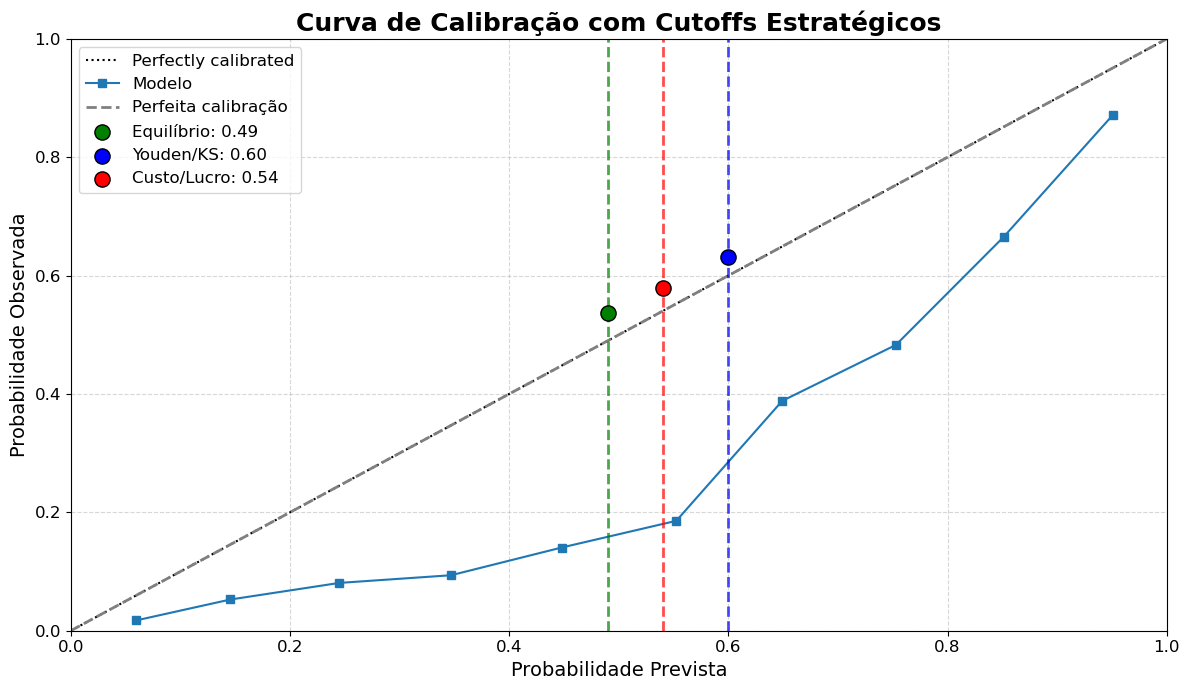

In [69]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

# -----------------------------
# Configuração da figura
# -----------------------------
plt.figure(figsize=(12,7))

# -----------------------------
# Curva de calibração
# -----------------------------
disp = CalibrationDisplay.from_predictions(
    y_test, 
    y_probs, 
    n_bins=10, 
    name="Modelo", 
    ax=plt.gca()
)

# -----------------------------
# Linha de referência perfeita
# -----------------------------
plt.plot([0,1], [0,1], linestyle='--', color='gray', label="Perfeita calibração", linewidth=2)

# -----------------------------
# Cutoffs estratégicos
# -----------------------------
cutoffs = {
    "Equilíbrio": cutoff_equilibrado,
    "Youden/KS": cutoff_youden,
    "Custo/Lucro": best_threshold
}

colors = {
    "Equilíbrio": "green",
    "Youden/KS": "blue",
    "Custo/Lucro": "red"
}

for label, thresh in cutoffs.items():
    # Linha vertical no threshold
    plt.axvline(thresh, color=colors[label], linestyle='--', linewidth=2, alpha=0.7)
    
    # Ponto aproximado na curva
    y_pos = y_test[y_probs >= thresh].mean()  # probabilidade real média acima do threshold
    plt.scatter(thresh, y_pos, color=colors[label], s=120, edgecolor='black', zorder=5, label=f"{label}: {thresh:.2f}")

# -----------------------------
# Títulos e labels
# -----------------------------
plt.title("Curva de Calibração com Cutoffs Estratégicos", fontsize=18, weight='bold')
plt.xlabel("Probabilidade Prevista", fontsize=14)
plt.ylabel("Probabilidade Observada", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()
plt.show()


### 🔹 Resumo dos Cutoffs Estratégicos

| Critério                   | Threshold |
|-----------------------------|-----------|
| Equilíbrio Sensibilidade/Especificidade | 0,49      |
| Otimização Estatística (Youden/KS)     | 0,60      |
| Otimização de Negócio (Custo/Lucro)    | 0,54     |


> Esses três thresholds servem como referência para diferentes estratégias: desde decisões neutras até decisões **orientadas por lucro**.


C:\Users\Marcos\AppData\Local\Temp\ipykernel_12360\1935220776.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bad_rate_bin = df_analysis.groupby('score_bin')['actual'].mean()
C:\Users\Marcos\AppData\Local\Temp\ipykernel_12360\1935220776.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bad_rate_bin.index.astype(str), y=bad_rate_bin.values, palette="RdYlGn_r")


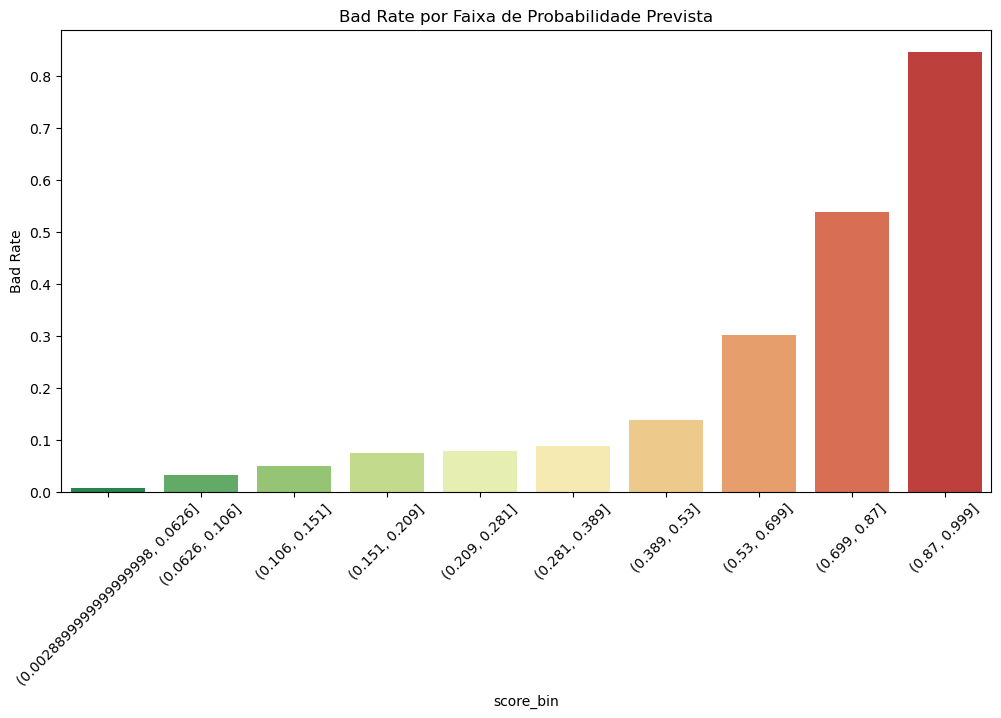

In [83]:
df_analysis = pd.DataFrame({
    'prob_pred': y_probs_final,
    'actual': y_test
})
df_analysis['score_bin'] = pd.qcut(df_analysis['prob_pred'], q=10)

bad_rate_bin = df_analysis.groupby('score_bin')['actual'].mean()

plt.figure(figsize=(12,6) )
sns.barplot(x=bad_rate_bin.index.astype(str), y=bad_rate_bin.values, palette="RdYlGn_r")
plt.xticks(rotation=45)
plt.ylabel("Bad Rate")
plt.title("Bad Rate por Faixa de Probabilidade Prevista")
plt.show()

### Análise por Decis de Risco

A base de teste foi segmentada em decis de probabilidade,
permitindo avaliar o poder de ordenação do modelo.

Observa-se uma concentração crescente da taxa de inadimplência
nos decis de maior risco, indicando boa capacidade discriminatória
e aplicabilidade prática do modelo em políticas de crédito.

In [84]:
results = pd.DataFrame({'target': y_test, 'prob': y_probs_final})
results['decil'] = pd.qcut(results['prob'], 10, labels=False)
results['decil'] = 9 - results['decil']  # inverte para crédito

decil_table = results.groupby('decil').agg(
    min_prob=('prob', 'min'),
    max_prob=('prob', 'max'),
    bad_rate=('target', 'mean'),
    total_clientes=('target', 'count')
).reset_index()
decil_table['bad_rate'] = decil_table['bad_rate'] * 100
print(decil_table)

   decil  min_prob  max_prob   bad_rate  total_clientes
0      0  0.870319  0.998629  84.700315             634
1      1  0.699788  0.869759  53.870458             633
2      2  0.530427  0.698979  30.126183             634
3      3  0.389066  0.530391  13.744076             633
4      4  0.280987  0.388829   8.832808             634
5      5  0.209203  0.280987   7.898894             633
6      6  0.150791  0.209111   7.413249             634
7      7  0.106478  0.150788   4.897314             633
8      8  0.062715  0.106353   3.154574             634
9      9  0.003886  0.062512   0.788644             634


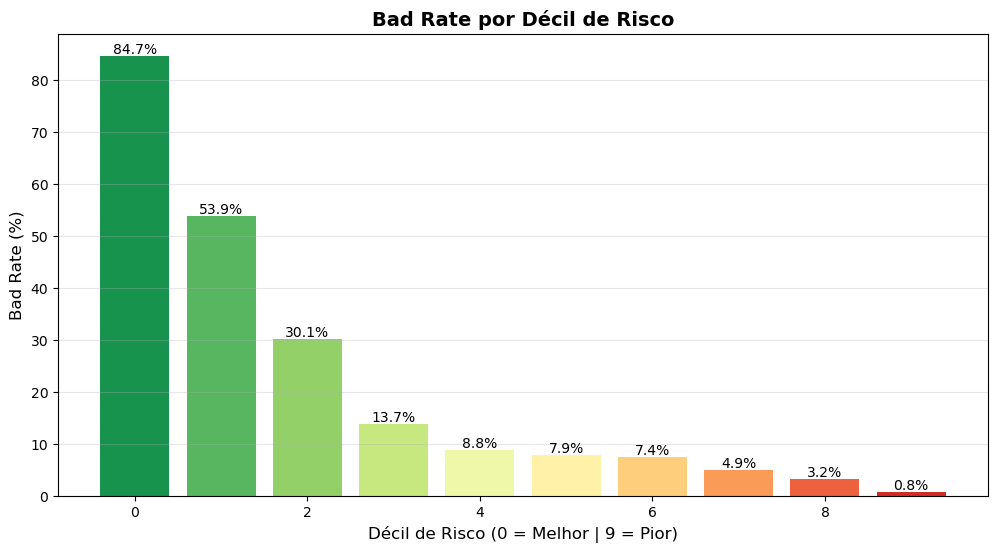

In [81]:
plt.figure(figsize=(12, 6))

# Cores graduais do verde ao vermelho
colors = sns.color_palette("RdYlGn_r", 10)

bars = plt.bar(
    decil_table['decil'],
    decil_table['bad_rate'],
    color=colors
)

# Adicionar valores no topo das barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}%', ha='center', fontsize=10)

plt.xlabel('Décil de Risco (0 = Melhor | 9 = Pior)', fontsize=12)
plt.ylabel('Bad Rate (%)', fontsize=12)
plt.title('Bad Rate por Décil de Risco', fontsize=14, weight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()


# 🏦 Score de Crédito e Política de Crédito Final

Nesta seção, traduzimos as **probabilidades previstas pelo modelo** em **score de crédito** e aplicamos a **política de crédito final**, considerando risco e custo de inadimplência.

---

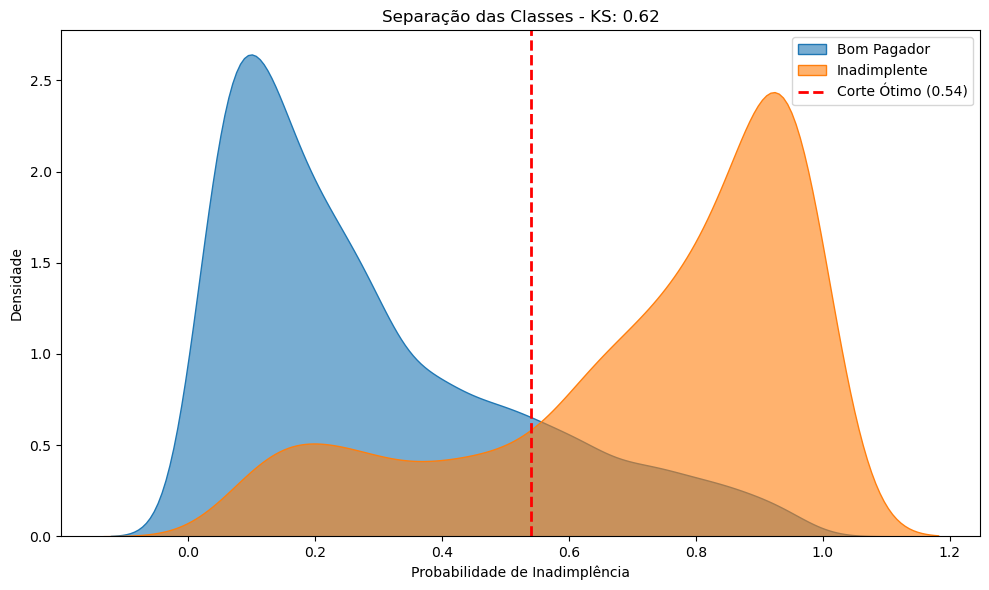

In [101]:
df_plot = df_test_final.copy()
df_plot['target'] = y_test.values

plt.figure(figsize=(10,6))
sns.kdeplot(data=df_plot[df_plot['target']==0], x='prob', fill=True, label='Bom Pagador', alpha=0.6)
sns.kdeplot(data=df_plot[df_plot['target']==1], x='prob', fill=True, label='Inadimplente', alpha=0.6)
plt.axvline(x=best_threshold, color='red', linestyle='--', linewidth=2, label=f'Corte Ótimo ({best_threshold:.2f})')
plt.title(f'Separação das Classes - KS: {ks_stat:.2f}')
plt.xlabel('Probabilidade de Inadimplência')
plt.ylabel('Densidade')
plt.legend()
plt.tight_layout()
plt.show()

### Política de Aprovação e Bad Rate da Carteira

Com base no threshold ótimo definido, foi estabelecida uma política
de aprovação que visa minimizar o custo total da operação.

A avaliação do Bad Rate da carteira aprovada confirma que o modelo
é capaz de reduzir o risco de inadimplência, mantendo equilíbrio
entre risco e volume aprovado.

In [85]:
threshold_final = best_threshold
results['aprovado'] = (results['prob'] < threshold_final).astype(int)

carteira_aprovada = results[results['aprovado'] == 1]
taxa_aprovacao = carteira_aprovada.shape[0] / results.shape[0]
bad_rate_aprovada = carteira_aprovada['target'].mean()

print(f"Taxa de Aprovação: {taxa_aprovacao:.2%}")
print(f"Bad Rate da Carteira Aprovada: {bad_rate_aprovada:.2%}")

Taxa de Aprovação: 70.69%
Bad Rate da Carteira Aprovada: 6.70%


Com o ponto de corte definido, o modelo aprovou cerca de 70,69% dos clientes,
resultando em um Bad Rate de 6,7% na carteira aprovada, o que demonstra um
equilíbrio adequado entre risco e volume, considerando o custo assimétrico
da inadimplência

### Interpretação dos Coeficientes (Odds Ratio)

Os coeficientes da regressão logística foram convertidos em Odds Ratios,
permitindo interpretar de forma direta o impacto de cada variável
sobre a chance de inadimplência.

In [87]:
# Criando a tabela de Odds Ratio
coef_df = pd.DataFrame({
    'Atributo': X_train_final.columns,
    'Coeficiente': final_model.coef_[0]
})

# O exponencial do coeficiente dá a Razão de Chances (Odds Ratio)
coef_df['Odds_Ratio'] = np.exp(coef_df['Coeficiente'])
coef_df = coef_df.sort_values(by='Odds_Ratio', ascending=False)

print("Top 5 Fatores de Risco (Aumentam a chance de inadimplência):")
print(coef_df.head(5))

print("\nTop 5 Fatores de Proteção (Diminuem a chance de inadimplência):")
print(coef_df.tail(5))

Top 5 Fatores de Risco (Aumentam a chance de inadimplência):
               Atributo  Coeficiente  Odds_Ratio
2   loan_percent_income     6.158821  472.870466
18         loan_grade_g     4.846459  127.288916
17         loan_grade_f     3.513877   33.578213
16         loan_grade_e     3.246147   25.691170
15         loan_grade_d     2.898054   18.138811

Top 5 Fatores de Proteção (Diminuem a chance de inadimplência):
                     Atributo  Coeficiente  Odds_Ratio
11       loan_intent_personal    -0.450362    0.637397
25            income_bin_87k+    -0.607610    0.544651
8       loan_intent_education    -0.670073    0.511671
12        loan_intent_venture    -1.030964    0.356663
6   person_home_ownership_own    -1.654061    0.191272


## 1️⃣ Cálculo do Score de Crédito (PDO)

- Utilizamos o método **PDO (Points to Double Odds)** para criar uma escala de score:  
  - **PDO:** 50 pontos para dobrar a probabilidade de inadimplência  
  - **Score Base:** 600  
  - **Odds Base:** 50 bons para 1 mau  

- O score é ajustado para uma **escala 0–1000**, facilitando interpretação e comparação entre clientes.

---

In [95]:
# -----------------------------
# 2️⃣ Cálculo do Score de Crédito (PDO)
# -----------------------------
PDO = 50           # Pontos para dobrar odds
score_base = 600   # Score base
odds_base = 50     # Odds base: 50 bons para 1 mau

B = PDO / np.log(2)
A = score_base - B * np.log(odds_base)

# Score logit
df_test_final['score'] = A + B * np.log((1 - df_test_final['prob']) / df_test_final['prob'])

# Ajuste para escala 0-1000
df_test_final['score_adj'] = (
    (df_test_final['score'] - df_test_final['score'].min()) /
    (df_test_final['score'].max() - df_test_final['score'].min())
) * 1000

df_test_final[['score', 'score_adj']].describe()

,score,score_adj
count,6336.000000,6336.000000
mean,364.270004,596.098380
std,129.691343,148.127567
min,-157.636899,0.000000
25%,284.872961,505.414680
50%,385.582832,620.440924
75%,456.044975,700.919586
max,717.901302,1000.000000


## 2️⃣ Bad Rate e Volume por Faixa de Score

- Dividimos os clientes em **10 faixas de score** e avaliamos:  
  - Número total de clientes por faixa  
  - Bad rate (inadimplência) por faixa  

- Essa análise permite **identificar segmentos de risco** e monitorar a carteira.

*Exemplo de gráfico:*

C:\Users\Marcos\AppData\Local\Temp\ipykernel_12360\1320734337.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_report = df_plot.groupby('score_bin').agg(


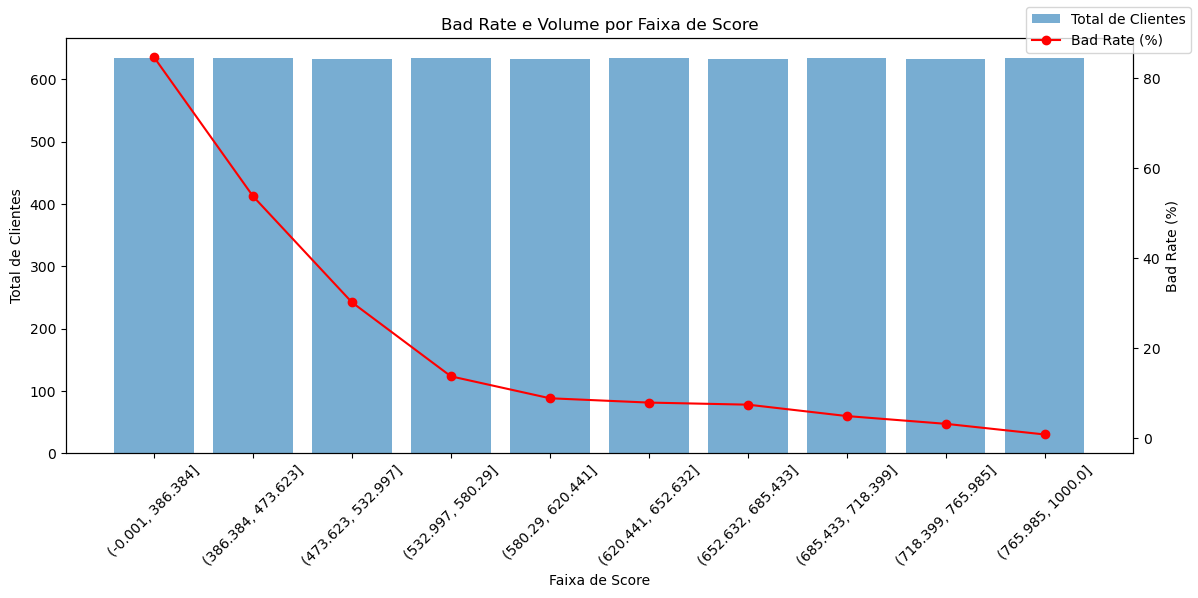

In [96]:
# -----------------------------
# 3️⃣ Bad Rate e Volume por Faixa de Score
# -----------------------------
df_plot = df_test_final.copy()
df_plot['target'] = y_test.values
df_plot['score_bin'] = pd.qcut(df_plot['score_adj'], 10)

score_report = df_plot.groupby('score_bin').agg(
    bad_rate=('target', 'mean'),
    total=('target', 'count')
).reset_index()

fig, ax1 = plt.subplots(figsize=(12,6))

# Barras: volume de clientes
ax1.bar(score_report['score_bin'].astype(str),
        score_report['total'],
        alpha=0.6,
        label='Total de Clientes')
ax1.set_ylabel('Total de Clientes')
ax1.set_xlabel('Faixa de Score')
ax1.tick_params(axis='x', rotation=45)

# Linha: bad rate
ax2 = ax1.twinx()
ax2.plot(score_report['score_bin'].astype(str),
         score_report['bad_rate']*100,
         color='red',
         marker='o',
         label='Bad Rate (%)')
ax2.set_ylabel('Bad Rate (%)')

plt.title('Bad Rate e Volume por Faixa de Score')
fig.legend(loc='upper right')
plt.tight_layout()
plt.show()

## 3️⃣ Definição do Score de Corte

- O **score de corte** é calculado a partir do **threshold de negócio** (0,54):  
  - Clientes com score >= score de corte → risco aceitável  
  - Clientes com score < score de corte → risco elevado  

- Este ponto garante que a política de crédito **balanceie risco e retorno**.

> Score de corte recomendado: 306 

---

In [97]:
# -----------------------------
# 4️⃣ Definição do Score de Corte
# -----------------------------
cut_prob = best_threshold  # Threshold de negócio (0,54)
cut_score = A + B * np.log((1 - cut_prob) / cut_prob)
print(f'Score de corte recomendado: {cut_score:.0f}')

Score de corte recomendado: 306


## 4️⃣ Política de Crédito Final

- Baseada no score, definimos 3 categorias:  

| Faixa de Score           | Decisão                 |
|--------------------------|------------------------|
| >= 700                   | Aprovação Automática   |
| >= Score de Corte        | Análise Manual         |
| < Score de Corte         | Recusa                 |

- A política garante que clientes de **alto risco sejam analisados com cautela**, enquanto clientes de **baixo risco sejam aprovados automaticamente**.

---

In [100]:
# -----------------------------
# 5️⃣ Política de Crédito Final
# -----------------------------
def politica_credito(score):
    if score >= 700:
        return 'Aprovação Automática'
    elif score >= cut_score:
        return 'Análise Manual'
    else:
        return 'Recusa'

df_test_final['decisao'] = df_test_final['score_adj'].apply(politica_credito)

policy_report = df_test_final.join(y_test).groupby('decisao').agg(
    total_clientes=('target','count'),
    bad_rate=('target','mean')
)
policy_report['bad_rate'] = policy_report['bad_rate'] * 100
policy_report

,total_clientes,bad_rate
decisao,,
Análise Manual,4476,24.218052
Aprovação Automática,1595,2.382445
Recusa,265,91.698113



## 5️⃣ Distribuição de Scores e Corte

- Visualizamos a **distribuição dos scores** e o **ponto de corte** da política:

- O gráfico mostra claramente o **volume de clientes** e onde **a política de corte separa aprovação automática, análise manual e recusa**.

---

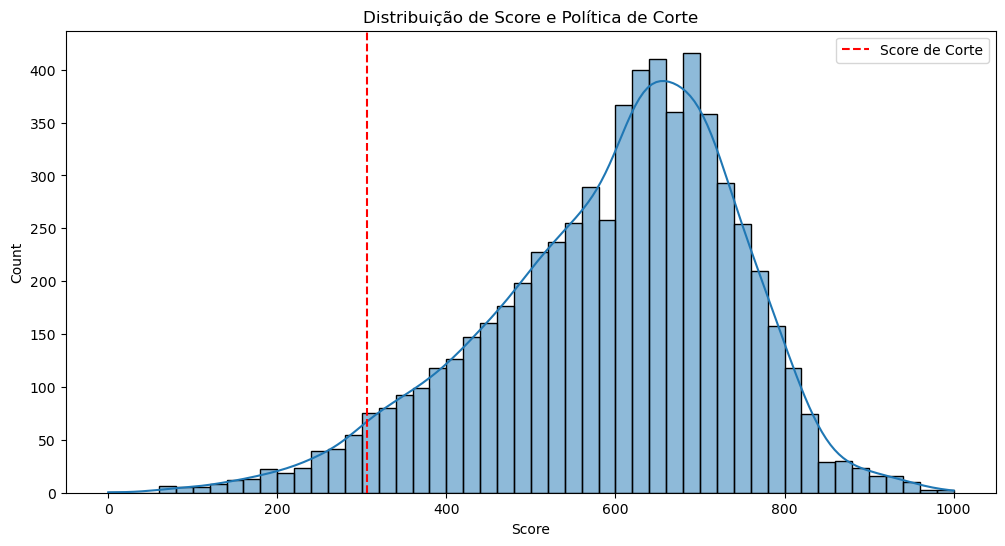

In [99]:
# -----------------------------
# 6️⃣ Visualização da Distribuição de Scores
# -----------------------------
plt.figure(figsize=(12,6))
sns.histplot(df_test_final['score_adj'], bins=50, kde=True)
plt.axvline(cut_score, color='red', linestyle='--', label='Score de Corte')
plt.title('Distribuição de Score e Política de Corte')
plt.xlabel('Score')
plt.legend()
plt.show()

### 🔹 Observações

- O score traduz a probabilidade prevista pelo modelo em **uma métrica facilmente aplicável na política de crédito**.  
- Permite monitoramento contínuo da **carteira de clientes** e decisões consistentes de aprovação/rejeição.  
- Facilita a comunicação de risco para áreas de negócio e auditoria.
